In [1255]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [1256]:
train = pd.read_csv('E:/Desafio_DS/ds-project/data/01_raw/train.csv')
test = pd.read_csv('E:/Desafio_DS/ds-project/data/01_raw/test.csv')

In [1257]:
train.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1258]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [1259]:
## Calculando a porcentagem que representa os valores nulos da coluna "Age"
percent_null = train['Age'].isnull().value_counts(normalize=True)
percent_null

False    0.801347
True     0.198653
Name: Age, dtype: float64

In [1260]:
## Calculando a porcentagem que representa os valores nulos da coluna "Cabin"
percent_null = train['Cabin'].isnull().value_counts(normalize=True)
percent_null

True     0.771044
False    0.228956
Name: Cabin, dtype: float64

In [1261]:
## Dropando valores nulos da coluna "Age"
train = train.dropna(subset=["Age"])
test = test.dropna(subset=["Age"])

In [1262]:
## Cria uma variável booleana para o sexo da pessoa. 1 = Mulher; 2 = Homem
train['Sex'] = (train['Sex'] == 'female').astype(int)
test['Sex'] = (test['Sex'] == 'female').astype(int)

In [1263]:
## Dropando valores nulos da coluna "Embarked"
train = train.dropna(subset=['Embarked'])
test = test.dropna(subset=['Embarked'])

In [1264]:
## Verificando a correlação entre "Survived" e "Age"
correlacao = train['Survived'].corr(train['Age'])
print(correlacao)

-0.08244586804341386


<seaborn.axisgrid.FacetGrid object at 0x000002EE48354A00>

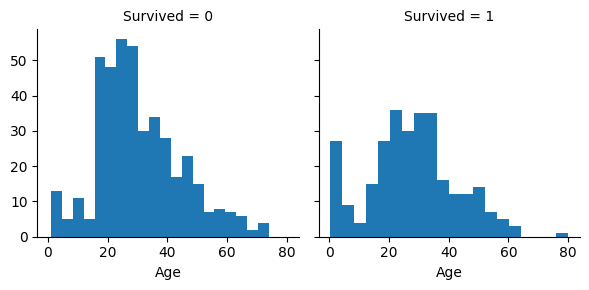

In [1265]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

In [1266]:
## Verificando a correlação entre "Survived" e "Sex"
correlacao = train['Survived'].corr(train['Sex'])
print(correlacao)

0.5367616233485025


In [1267]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
1,1,0.752896
0,0,0.205298


In [1268]:
## Verificando a correlação entre "Survived" e "SibSp"
correlacao = train['Survived'].corr(train['SibSp'])
print(correlacao)

-0.015523023631749488


In [1269]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.530055
2,2,0.440000
0,0,0.368870
3,3,0.333333
4,4,0.166667
5,5,0.000000


In [1270]:
## Verificando a correlação entre "Survived" e "Parch"
correlacao = train['Survived'].corr(train['Parch'])
print(correlacao)

0.09526529428685283


In [1271]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
2,2,0.573529
1,1,0.554545
0,0,0.354528
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [1272]:
## Verificando a correlação entre "Survived" e "Pclass"
correlacao = train['Survived'].corr(train['Pclass'])
print(correlacao)

-0.35646158844523856


In [1273]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.652174
1,2,0.479769
2,3,0.239437


<seaborn.axisgrid.FacetGrid object at 0x000002EE4F612B80>

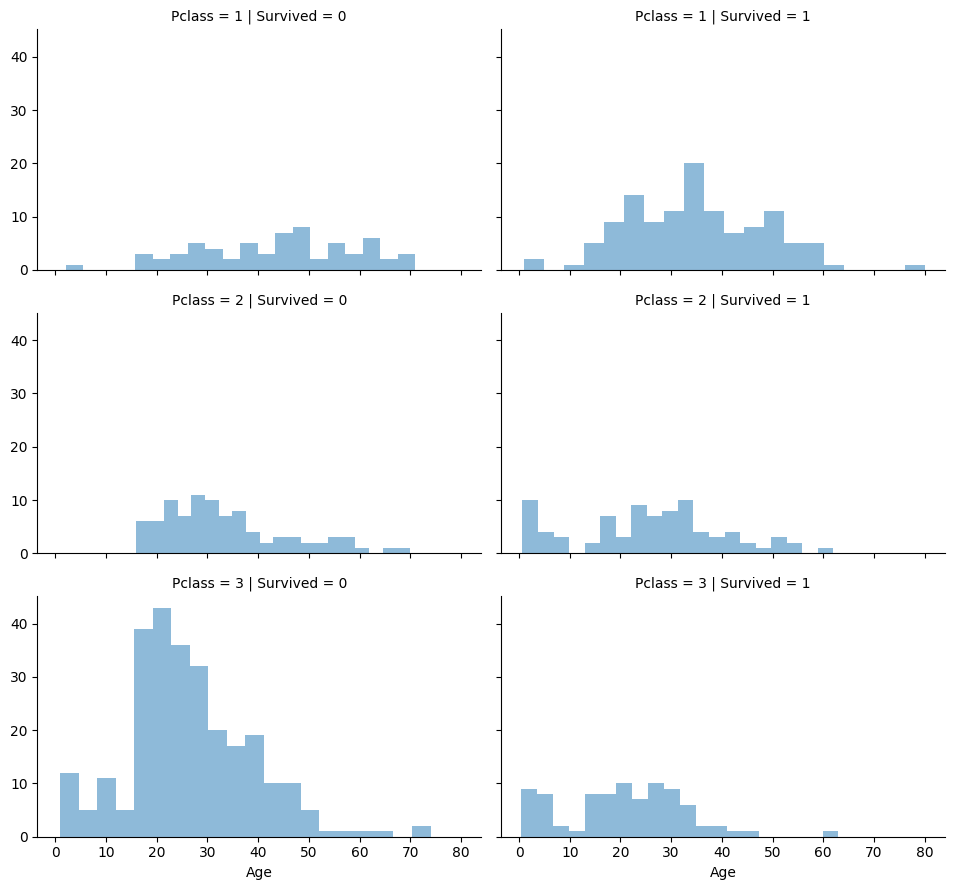

In [1274]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [1275]:
## Verificando a correlação entre "Survived" e "Embarked"
mapa_letras_para_numeros = {'S': 1, 'C': 2, 'Q': 3}
train['Embarked_num'] = train['Embarked'].replace(mapa_letras_para_numeros)
train['Embarked_num'] = pd.to_numeric(train['Embarked_num'])
correlacao = train['Survived'].corr(train['Embarked_num'])
print(correlacao)

0.108516822554197


In [1276]:
## Verificando a correlação entre "Survived" e "Fare"
correlacao = train['Survived'].corr(train['Fare'])
print(correlacao)

0.2660996004765802


In [1277]:
## Dropando colunas que não vão fazer sentido para o modelo
train = train.drop(columns=['Cabin','Ticket', 'PassengerId', 'Embarked_num'])
test = test.drop(columns=['Cabin','Ticket', 'PassengerId'])
train = train.drop(columns='Name')
test = test.drop(columns='Name')
train = train.drop(columns='SibSp')
test = test.drop(columns='SibSp')
train = train.drop(columns='Parch')
test = test.drop(columns='Parch')

In [1278]:
## Definindo os dados como type = category
train['Pclass'] = train['Pclass'].astype('category')
train['Sex'] = train['Sex'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
test['Pclass'] = test['Pclass'].astype('category')
test['Sex'] = test['Sex'].astype('category')
test['Embarked'] = test['Embarked'].astype('category')

In [1279]:
## Resetando o index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [1280]:
## OneHotEncoder
enc = OneHotEncoder(handle_unknown = 'ignore')
enc_data = pd.DataFrame(enc.fit_transform(train[['Pclass','Sex','Embarked']]).toarray())
enc_data_test = pd.DataFrame(enc.fit_transform(test[['Pclass','Sex','Embarked']]).toarray())    

In [1281]:
## Fazendo o join do encoder e dropando as colunas
train.join(enc_data).drop(columns=['Pclass','Embarked'])
test.join(enc_data_test).drop(columns=['Pclass','Embarked'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [1282]:
## Convertendo as variáveis em dummies
train = pd.get_dummies(train, columns=['Pclass', 'Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Pclass', 'Sex', 'Embarked'])

In [1283]:
## Resetando o index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [1284]:
## Definindo X e Y, e pegando 1/3 dos dados para testes
train_fixed = train
test_fixed = test
X = train_fixed.iloc[:,1:]
Y = train_fixed.iloc[:,0]
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [1285]:
## Criando o modelo
model = xgb.XGBClassifier()
le = LabelEncoder()
y_train = le.fit_transform(y_train)
model.fit(X_train, y_train)
test_fixed = test_fixed[['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0', 'Sex_1',
     'Embarked_C', 'Embarked_Q', 'Embarked_S']]

In [1286]:
## Salvando a predição
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [1287]:
## Testando a acuracia 
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.98%
